In [2]:
import pandas as pd
import numpy as np
import cv2
import csv
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn import linear_model

In [3]:
inputVideo = "input/13th australia queensland.avi"
inputSyncLog = "output/13thFinalLog.csv"

In [5]:
df = pd.read_csv(inputSyncLog)
capVid = cv2.VideoCapture(inputVideo)
frame_width = int(capVid.get(3))
frame_height = int(capVid.get(4))
out = cv2.VideoWriter('output/13thFeatureExtBlackOut.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 9, (1080,480))
font = cv2.FONT_HERSHEY_SIMPLEX
black = [0,0,0]

ret,imgO1 = capVid.read()
img1 = imgO1.copy()
for x in range(323,323+263):
        for y in range(445,445+50):
            img1[y,x] = black
# initialize counter to update roll, pitch, yaw
i = 0

list_roll_pitch_yaw = []
list_time = []

# Initiate ORB detector
orb = cv2.ORB_create()
    
while(1):
    frameOrder = 7
    for a in range(frameOrder): # 7, 14
        ret,imgO2 = capVid.read()
    
    img2 = imgO2.copy()
    for x in range(323,323+263):
        for y in range(445,445+50):
            img2[y,x] = black
            
    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    if kp1 and kp2:
        if (len(kp1) > 4 and len(kp2) > 4):
            # Match descriptors.
            matches = bf.match(des1,des2)

            # Sort them in the order of their distance.
            matches = sorted(matches, key = lambda x:x.distance)
            
            roll = df.iloc[i*frameOrder]['roll']
            pitch = df.iloc[i*frameOrder]['pitch']
            yaw = df.iloc[i*frameOrder]['yaw']
            time = df.iloc[i*frameOrder]['time']

            rollNext = df.iloc[i*frameOrder + frameOrder]['roll']
            pitchNext = df.iloc[i*frameOrder + frameOrder]['pitch']
            yawNext = df.iloc[i*frameOrder + frameOrder]['yaw']
            
            # Initialize lists to store keypoints 
            list_kp1 = []
            list_kp2 = []

            # For each match...
            for mat in matches:
                # Get the matching keypoints for each of the images
                img1_idx = mat.queryIdx
                img2_idx = mat.trainIdx

                # x - columns
                # y - rows
                # Get the coordinates
                (x1, y1) = kp1[img1_idx].pt
                (x2, y2) = kp2[img2_idx].pt

                # Append to each list
                list_kp1.append((x1, y1))
                list_kp2.append((x2, y2))
    
    
            startFrame = i*frameOrder
            endFrame = i*frameOrder + frameOrder
    
            list_roll_pitch_yaw_i = [(startFrame, endFrame) + startPt + endPt + (roll, pitch, yaw) + (rollNext, pitchNext, yawNext) for startPt, endPt in zip(list_kp1, list_kp2)]
            list_roll_pitch_yaw.extend(list_roll_pitch_yaw_i)
        
            list_time.append(time)

            # for viewing un-comment the following to see top 30 features matching lines, and press escape to close the window
            img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:], None,flags=2)
            imgResize = cv2.resize(img3, (1080, 480))
            cv2.putText(imgResize,  
                'roll : {:.2f}'.format(roll),  
                (50, 60),  
                font, 1,  
                (0, 255, 255),  
                2,  
                cv2.LINE_4) 
            cv2.putText(imgResize,  
                'pitch :{:.2f}'.format(pitch),  
                (50, 80),  
                font, 1,  
                (0, 255, 255),  
                2,  
                cv2.LINE_4) 
            cv2.putText(imgResize,  
                'yaw :{:.2f}'.format(yaw),  
                (50, 100),  
                font, 1,  
                (0, 255, 255),  
                2,  
                cv2.LINE_4) 
            cv2.putText(imgResize,  
                'time :{}'.format(time),  
                (50, 120),  
                font, 1,  
                (0, 255, 255),  
                2,  
                cv2.LINE_4) 
            
            out.write(imgResize) 
            cv2.imshow('Feature Matching',imgResize)
    
    img1 = img2.copy()
    i = i + 1
    
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    
cv2.destroyAllWindows()
capVid.release()
out.release()

In [6]:
list1 = list_time
list2 = list_roll_pitch_yaw
list3 = zip(list1,list2)

In [7]:
with open('output/13thTrainingBlackOut.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['StartFrame','EndFrame','x1','y1','x2','y2','Roll1','Pitch1','Yaw1', 'Roll2','Pitch2','Yaw2'])
    for row in list2:
        csv_out.writerow(row)

In [4]:
df = pd.read_csv('output/13thTrainingBlackOut.csv')
df.shape

(103913, 12)

In [9]:
df.head()

,StartFrame,EndFrame,x1,y1,x2,y2,Roll1,Pitch1,Yaw1,Roll2,Pitch2,Yaw2
0,0,7,420.000031,303.600006,420.000031,344.400024,0.003907,0.973236,26.96,0.00165,0.9719,26.96
1,0,7,570.240051,311.040039,570.240051,350.784027,0.003907,0.973236,26.96,0.00165,0.9719,26.96
2,0,7,500.000000,31.000000,500.000000,31.000000,0.003907,0.973236,26.96,0.00165,0.9719,26.96
3,0,7,554.400024,327.600006,554.400024,368.400024,0.003907,0.973236,26.96,0.00165,0.9719,26.96
4,0,7,230.400009,375.840027,216.000015,420.480011,0.003907,0.973236,26.96,0.00165,0.9719,26.96


In [43]:
df.tail()

,StartFrame,EndFrame,x1,y1,x2,y2,Roll1,Pitch1,Yaw1,Roll2,Pitch2,Yaw2
1260079,3107,3108,547.776062,423.360046,547.430481,425.088074,16.31318,-35.23164,343.1633,16.30692,-35.22524,343.11522
1260080,3107,3108,434.880005,460.800018,434.880005,460.800018,16.31318,-35.23164,343.1633,16.30692,-35.22524,343.11522
1260081,3107,3108,601.344055,358.732849,601.344055,359.424042,16.31318,-35.23164,343.1633,16.30692,-35.22524,343.11522
1260082,3107,3108,337.996857,402.278442,338.688019,400.896027,16.31318,-35.23164,343.1633,16.30692,-35.22524,343.11522
1260083,3107,3108,705.024109,445.824066,705.024048,447.552032,16.31318,-35.23164,343.1633,16.30692,-35.22524,343.11522


In [5]:
df['dx'] = df['x1']-df['x2']
df['dy'] = df['y1']-df['y2']
df['deltaRoll'] = df['Roll1'] - df['Roll2']
df['deltaPitch'] = df['Pitch1'] - df['Pitch2']
df['deltaYaw'] = df['Yaw1'] - df['Yaw2']

In [45]:
df.head()

,StartFrame,EndFrame,x1,y1,x2,y2,Roll1,Pitch1,Yaw1,Roll2,Pitch2,Yaw2,dx,dy,deltaRoll,deltaPitch,deltaYaw
0,0,1,380.0,460.0,380.0,460.0,0.003907,0.973236,26.96,0.0036,0.973036,26.96,0.0,0.0,0.000307,0.0002,0.0
1,0,1,387.0,460.0,387.0,460.0,0.003907,0.973236,26.96,0.0036,0.973036,26.96,0.0,0.0,0.000307,0.0002,0.0
2,0,1,370.0,459.0,370.0,459.0,0.003907,0.973236,26.96,0.0036,0.973036,26.96,0.0,0.0,0.000307,0.0002,0.0
3,0,1,568.0,459.0,568.0,459.0,0.003907,0.973236,26.96,0.0036,0.973036,26.96,0.0,0.0,0.000307,0.0002,0.0
4,0,1,373.0,459.0,373.0,459.0,0.003907,0.973236,26.96,0.0036,0.973036,26.96,0.0,0.0,0.000307,0.0002,0.0


In [46]:
df.tail()

,StartFrame,EndFrame,x1,y1,x2,y2,Roll1,Pitch1,Yaw1,Roll2,Pitch2,Yaw2,dx,dy,deltaRoll,deltaPitch,deltaYaw
1260079,3107,3108,547.776062,423.360046,547.430481,425.088074,16.31318,-35.23164,343.1633,16.30692,-35.22524,343.11522,0.345581,-1.728027,0.00626,-0.0064,0.04808
1260080,3107,3108,434.880005,460.800018,434.880005,460.800018,16.31318,-35.23164,343.1633,16.30692,-35.22524,343.11522,0.000000,0.000000,0.00626,-0.0064,0.04808
1260081,3107,3108,601.344055,358.732849,601.344055,359.424042,16.31318,-35.23164,343.1633,16.30692,-35.22524,343.11522,0.000000,-0.691193,0.00626,-0.0064,0.04808
1260082,3107,3108,337.996857,402.278442,338.688019,400.896027,16.31318,-35.23164,343.1633,16.30692,-35.22524,343.11522,-0.691162,1.382416,0.00626,-0.0064,0.04808
1260083,3107,3108,705.024109,445.824066,705.024048,447.552032,16.31318,-35.23164,343.1633,16.30692,-35.22524,343.11522,0.000061,-1.727966,0.00626,-0.0064,0.04808


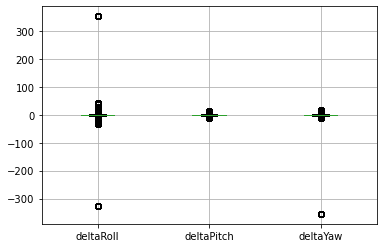

In [51]:
#df.boxplot(column=['dx','dy'])
df.boxplot(column=['deltaRoll', 'deltaPitch', 'deltaYaw'])

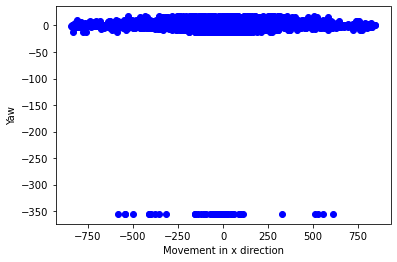

In [25]:
plt.scatter([df.dx], [df.deltaYaw],  color='blue')
plt.xlabel("Movement in x direction")
plt.ylabel("Yaw")
plt.show()

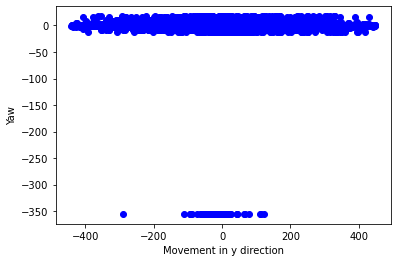

In [23]:
plt.scatter([df.dy], [df.deltaYaw],  color='blue')
plt.xlabel("Movement in y direction")
plt.ylabel("Yaw")
plt.show()

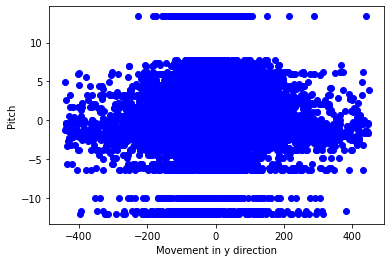

In [26]:
plt.scatter([df.dy], [df.deltaPitch],  color='blue')
plt.xlabel("Movement in y direction")
plt.ylabel("Pitch")
plt.show()

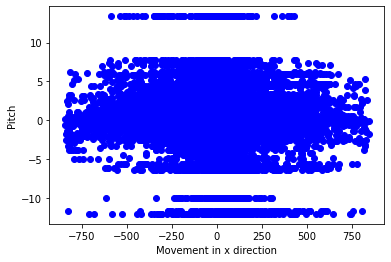

In [39]:
plt.scatter([df.dx], [df.deltaPitch],  color='blue')
plt.xlabel("Movement in x direction")
plt.ylabel("Pitch")
plt.show()

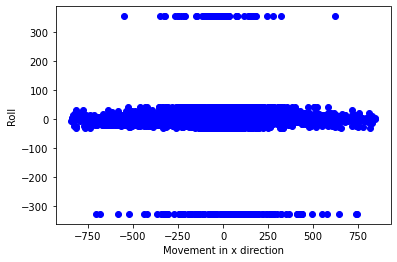

In [28]:
plt.scatter([df.dx], [df.deltaRoll],  color='blue')
plt.xlabel("Movement in x direction")
plt.ylabel("Roll")
plt.show()

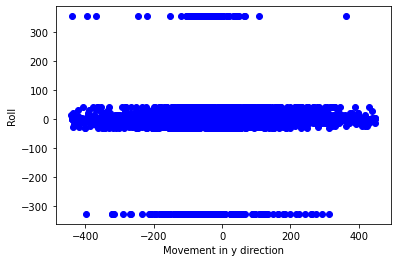

In [29]:
plt.scatter([df.dy], [df.deltaRoll],  color='blue')
plt.xlabel("Movement in y direction")
plt.ylabel("Roll")
plt.show()

In [81]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
train_x = np.asanyarray(train[['dx', 'dy']])
train_y = np.asanyarray(train[['deltaPitch']])

test_x = np.asanyarray(test[['dx', 'dy']])
test_y = np.asanyarray(test[['deltaPitch']])


poly3 = PolynomialFeatures(degree=20)
train_x_poly3 = poly3.fit_transform(train_x)
model3 = linear_model.LinearRegression()
train_y3_ = model3.fit(train_x_poly3, train_y)
# The coefficients
#print ('Coefficients: ', model3.coef_)
#print ('Intercept: ',model3.intercept_)
test_x_poly3 = poly3.fit_transform(test_x)
test_y3_ = model3.predict(test_x_poly3)

# evaluation
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y3_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y3_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y3_ , test_y) )

Mean absolute error: 1.31
Residual sum of squares (MSE): 4.66
R2-score: -60.78


In [58]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [82]:
lasso = Lasso()
parameters = {'alpha':np.linspace(0.0001, 0.0004, 10)}
lasso_regressor = GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=10)
lasso_regressor.fit(train_x, train_y)
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 0.0004}
-4.691803185967309


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

X = np.asanyarray(df[['dx', 'dy']])
y = np.asanyarray(df[['deltaPitch']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc_x = StandardScaler()
sc_y = StandardScaler()
#y_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
y_train_std = sc_y.fit_transform(y_train)
X_train_std = sc_x.fit_transform(X_train)
X_test_std = sc_x.fit_transform(X_test)

r2_train = []
r2_test = []
norm = []

#alpha = np.linspace(0.0005, 0.001, 10)
alpha = np.linspace(0.00008, 0.0004, 30)

for i in range(30):
    lasso = Lasso(alpha = alpha[i])
    lasso.fit(X_train_std, y_train_std)
    y_train_std = lasso.predict(X_train_std)
    y_test_std = lasso.predict(X_test_std)
    r2_train = np.append(r2_train, r2_score(y_train, sc_y.inverse_transform(y_train_std)))
    r2_test = np.append(r2_test, r2_score(y_test, sc_y.inverse_transform(y_test_std)))
    norm = np.append(norm, np.linalg.norm(lasso.coef_))
    
#print(lasso.best_params_)
print(lasso.score)

<bound method RegressorMixin.score of Lasso(alpha=0.0004)>


In [84]:
print(r2_test[0])

0.0007763320698390697


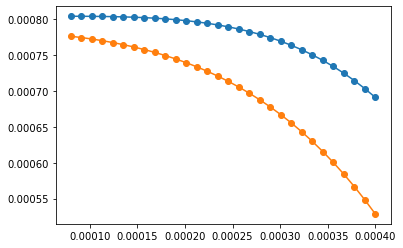

In [85]:
plt.scatter(alpha, r2_train, label='r2_train')
plt.plot(alpha, r2_train)
plt.scatter(alpha, r2_test, label='r2_test')
plt.plot(alpha, r2_test)
#plt.scatter(alpha, norm, label='norm')
#plt.plot(alpha, norm)